In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка и создание новых признаков

Сначала давайте объединим немного наши таблицы, чтобы из четырёх датасетов сделать два, с которыми мы будем работать(мы можем это сделать благодаря общему столбцу pid и файлу item.scv, который содержит информацию о товаре). main_df будет обучающей выборкой, которую мы поисследуем в EDA и с помощью которой потом обучим модель, а test_df будет тестовой выборкой, с помощью которой мы оценим нашу модель.

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Данные для проекта/train.csv",sep = "|")
df_item = pd.read_csv("https://raw.githubusercontent.com/Tiiiimmy/Andan_final_project/refs/heads/main/Data_for_project/items.csv", sep = "|")
main_df = pd.merge(df_train, df_item, how='left', on='pid' )


df_class = pd.read_csv("/content/drive/MyDrive/Данные для проекта/class.csv",sep = "|")
df_class.set_index('lineID',inplace=True,drop=True)
df_realclass = pd.read_csv("https://raw.githubusercontent.com/Tiiiimmy/Andan_final_project/refs/heads/main/Data_for_project/realclass.csv",sep = "|")
df_realclass.rename(columns={'revenue':'actual_revenue'},inplace=True)
df_realclass.set_index("lineID",inplace=True,drop=True)
test_df = df_class.join(df_realclass,on='lineID',how='inner')
test_df = pd.merge( test_df, df_item, how='left', on='pid' )

**Пропуски**

Поглядим, есть ли у нас пропуски и что с этим можно сделать

In [4]:
print(main_df.isna().mean())
print(test_df.isna().mean())

lineID             0.000000
day                0.000000
pid                0.000000
adFlag             0.000000
availability       0.000000
competitorPrice    0.036534
click              0.000000
basket             0.000000
order              0.000000
price              0.000000
revenue            0.000000
manufacturer       0.000000
group              0.000000
content            0.000000
unit               0.000000
pharmForm          0.070437
genericProduct     0.000000
salesIndex         0.000000
category           0.031710
campaignIndex      0.830176
rrp                0.000000
dtype: float64
day                0.000000
pid                0.000000
adFlag             0.000000
availability       0.000000
competitorPrice    0.031389
price              0.000000
actual_revenue     0.000000
manufacturer       0.000000
group              0.000000
content            0.000000
unit               0.000000
pharmForm          0.061086
genericProduct     0.000000
salesIndex         0.000000
categ

В campaignIndex почти 80% пропусков, то есть очень мало продуктов участвуют в какой-то рекламной компании. При этом у нас есть adFlag, который показывает, участвует ли продкут в рекламной компании. Я решил, что для исследования про динамическое ценообразование хватит и просто факта, что продукт участвует в рекламной компании, поэтому удалил этот столбец.

In [5]:
main_df = main_df.drop('campaignIndex', axis=1)
test_df = test_df.drop('campaignIndex', axis=1)

В competitor price не так много пропусков и поскольку это, по сути, столбец про наименьшие рыночные цены на каждую позицию, то можно просто заменить эти три процента средним по столбцу.

In [6]:
main_df['competitorPrice'] = main_df['competitorPrice'].fillna(main_df['competitorPrice'].mean())
test_df['competitorPrice'] = test_df['competitorPrice'].fillna(test_df['competitorPrice'].mean())

Проверим, есть ли в столбце category нули и, если нет, просто заменим все пропуски нулями, обозначающими, что категория товара не определена. Так как это категориальный признак, это нам никак не повредит. Такой же трюк проделаем с pharmForm: для неизвествных нам форм так и укажем -- 'Unknown'.

In [7]:
print((main_df['category'] == 0).any())
print((test_df['category'] == 0).any())

False
False


Нулей нет -- работаем

In [8]:
main_df['category'].fillna(0)
test_df['category'].fillna(0)
main_df['pharmForm'] = main_df['pharmForm'].fillna('Unknown')
test_df['pharmForm'] = test_df['pharmForm'].fillna('Unknown')

In [9]:
print(main_df.isna().mean())
print(test_df.isna().mean())

lineID             0.00000
day                0.00000
pid                0.00000
adFlag             0.00000
availability       0.00000
competitorPrice    0.00000
click              0.00000
basket             0.00000
order              0.00000
price              0.00000
revenue            0.00000
manufacturer       0.00000
group              0.00000
content            0.00000
unit               0.00000
pharmForm          0.00000
genericProduct     0.00000
salesIndex         0.00000
category           0.03171
rrp                0.00000
dtype: float64
day                0.000000
pid                0.000000
adFlag             0.000000
availability       0.000000
competitorPrice    0.000000
price              0.000000
actual_revenue     0.000000
manufacturer       0.000000
group              0.000000
content            0.000000
unit               0.000000
pharmForm          0.000000
genericProduct     0.000000
salesIndex         0.000000
category           0.023967
rrp                0.0000

**Типы данных**
Поменяем тип столбца category на category и тип столбца day на date(последнее просто удобнее будет, так-то здесь это непринципиально, день можно выбрать любой, в данных об этом ничего нет).

In [10]:
main_df['category'] = main_df['category'].astype('category')
test_df['category'] = test_df['category'].astype('category')
main_df['day'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(main_df['day'] - 1, unit='D')
test_df['day'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['day'] - 1, unit='D')
test_df['category'] = test_df['category'].astype('category')

__Создание новых переменных:__
нам для наших целей могут быть полезные разные переменные связанные с ценами. Точно хотелось бы посмотреть на превышение наших цен над рыночными, поэтому я решил создать столбец, где это будет показано и столбец, где будет указано, на сколько превышает.

In [11]:
main_df['competitor_cheaper'] = main_df['price'] > main_df['competitorPrice']
test_df['competitor_cheaper'] = test_df['price'] > test_df['competitorPrice']

main_df['price_difference'] = main_df['price'] - main_df['competitorPrice']
test_df['price_difference'] = test_df['price'] - test_df['competitorPrice']

main_df['discount'] = main_df['rrp'] - main_df['price']
test_df['discount'] = test_df['rrp'] - test_df['price']

main_df['competitor_cheaper'] = main_df['competitor_cheaper'].astype(int)
test_df['competitor_cheaper'] = test_df['competitor_cheaper'].astype(int)

__Итоговый main_df__:

In [12]:
main_df

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,content,unit,pharmForm,genericProduct,salesIndex,category,rrp,competitor_cheaper,price_difference,discount
0,1,2024-01-01,6570,0,2,14.60,1,0,0,16.89,...,50,ML,TRO,0,40,193.0,18.25,1,2.29,1.36
1,2,2024-01-01,14922,1,1,8.57,0,1,0,8.75,...,50,ST,TAB,1,40,66.0,18.81,1,0.18,10.06
2,3,2024-01-01,16382,0,1,14.77,0,1,0,16.06,...,2X50,ML,STI,0,53,40.0,18.48,1,1.29,2.42
3,4,2024-01-01,1145,1,1,6.59,0,0,1,6.55,...,60,G,GEL,0,40,25.0,9.31,0,-0.04,2.76
4,5,2024-01-01,3394,0,1,4.39,0,0,1,4.14,...,25X2,ST,KOM,0,53,14.0,8.13,0,-0.25,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2755999,2024-04-01,15767,0,1,22.41,1,0,0,18.64,...,15,ML,LOT,0,53,15.0,24.75,0,-3.77,6.11
2755999,2756000,2024-04-01,2087,0,1,36.87,1,0,0,43.18,...,200,ST,KAP,0,40,100.0,46.09,1,6.31,2.91
2756000,2756001,2024-04-01,2944,0,1,4.71,1,0,0,5.59,...,25,ST,DRA,0,53,1.0,5.88,1,0.88,0.29
2756001,2756002,2024-04-01,3853,1,1,6.59,0,1,0,6.33,...,50,G,SAL,0,40,90.0,9.58,0,-0.26,3.25


# EDA

Можно выделить два основных направления, которые интересно поизучать:

1. Поскольку аптека ввела динамическое ценообразование  прогнозировать нам придётся выручку, интересно было бы посмотреть на переменные, связанные с этими показателями.
2. У нас есть достаточно много информации про действия пользователей, что может быть полезно для прогнозирования выручки.

Начнём с первого:
Интересно посмотреть есть ли связь между динамически сформированными ценами нашей аптеки и ценами конкурентов(по сути, рыночными). Построим для этого диаграмму рассеивания.

Окажется, что присутствует линейная положительная связь между нашей ценой и ценой конкурентов. Также видно, что есть серьёзные выбросы с нашей стороны(цены около 350, когда рыночные не превышают 25).

Text(0, 0.5, 'Рыночная цена')

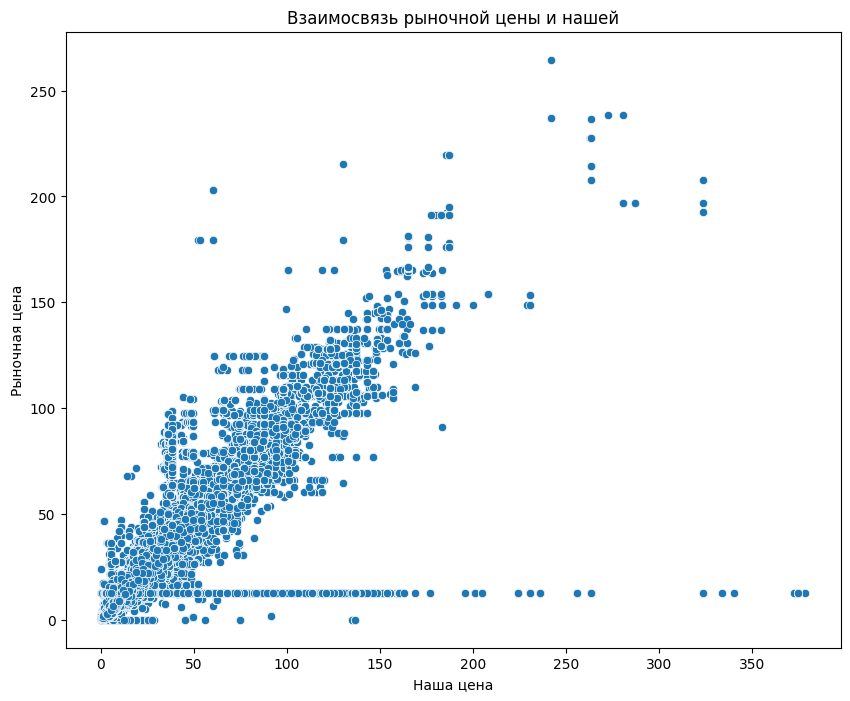

In [13]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=main_df, x='price', y='competitorPrice')
plt.title('Взаимосвязь рыночной цены и нашей')
plt.xlabel('Наша цена')
plt.ylabel('Рыночная цена')

Если, к тому же, проверить как отличаются наша средняя цена от их, то окажется, что несмотря на наличие положительной линейной связи между нашими ценами, аптеке благодаря динамическому ценообразованию удаётся ставить цены выше в 71% случаев

In [14]:
print(f"Доля случаев превышения нашей цены над рыночной : {main_df['competitor_cheaper'].mean():.2f}")
print(main_df['competitorPrice'].mean())
print(main_df['price'].mean())

Доля случаев превышения нашей цены над рыночной : 0.71
12.772879581940538
13.850083294539232


Как это тогда отражается на прибыли аптеки?

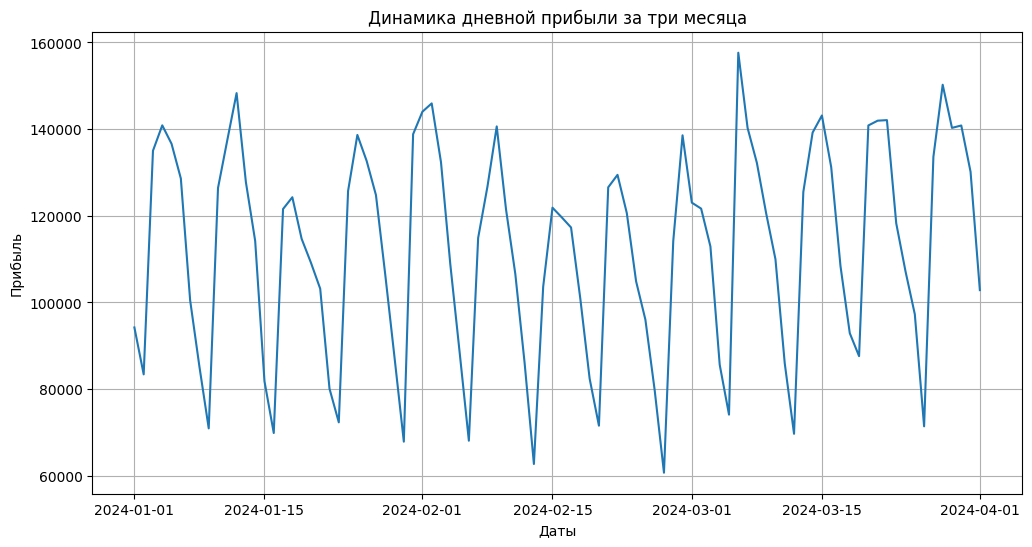

In [20]:
daily_profit = main_df.groupby('day')['revenue'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_profit.index, daily_profit.values)
plt.xlabel('Даты')
plt.ylabel('Прибыль')
plt.title('Динамика дневной прибыли за три месяца')
plt.grid(True)
plt.show()



<ipython-input-26-1cddf10aa471>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='revenue', data=monthly_profit, palette='viridis')


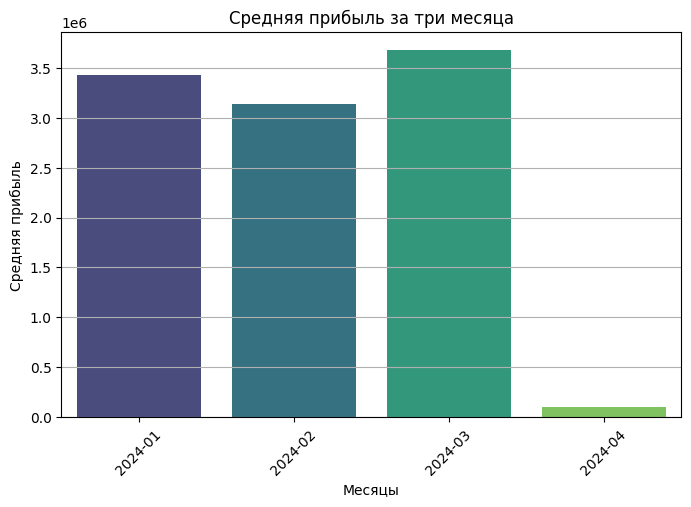

In [26]:
daily_profit['day'] = pd.to_datetime(daily_profit['day'])

daily_profit = daily_profit.reset_index()
daily_profit['month'] = daily_profit['day'].dt.to_period('M')


monthly_profit = daily_profit.groupby('month')['revenue'].sum().reset_index()

monthly_profit['month'] = monthly_profit['month'].dt.strftime('%Y-%m')

plt.figure(figsize=(8, 5))
sns.barplot(x='month', y='revenue', data=monthly_profit, palette='viridis')
plt.title('Средняя прибыль за три месяца')
plt.xlabel('Месяцы')
plt.ylabel('Средняя прибыль')
plt.grid(axis='y')
plt.xticks(rotation=45)

plt.show()


По трём месяцам, конечно, сложно, сказать, но в третий месяц прибль стала уже ощутима больше, чем в первые два.

Но насколько это связано именно с ценами и с реакцией людей на них? Можно построит диаграмму рассеивания для цены и прибыли(я потом упакаю эти два графика, чтобы они в одном figure были, тут пока просто смотрел, что вообще происходит).

Text(0, 0.5, 'Прибыль')

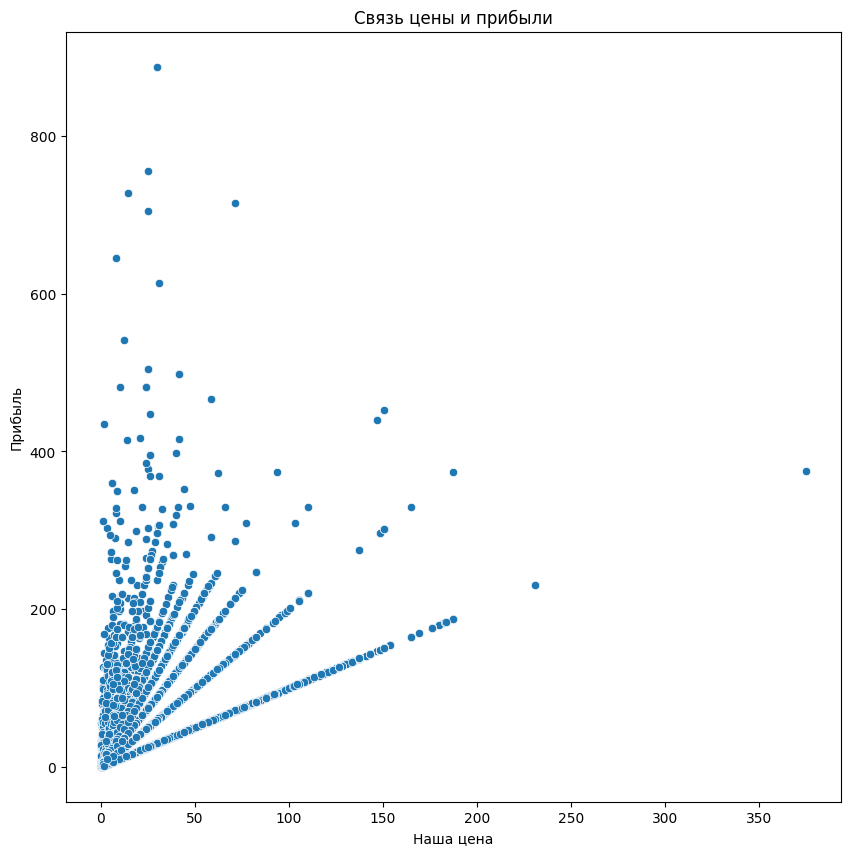

In [27]:
plt.figure(figsize=(10, 10))
df_temp = main_df[main_df['order']==1]
sns.scatterplot(data=df_temp, x='price', y='revenue')
plt.title('Связь цены и прибыли')
plt.xlabel('Наша цена')
plt.ylabel('Прибыль')

Text(0, 0.5, 'Прибыль')

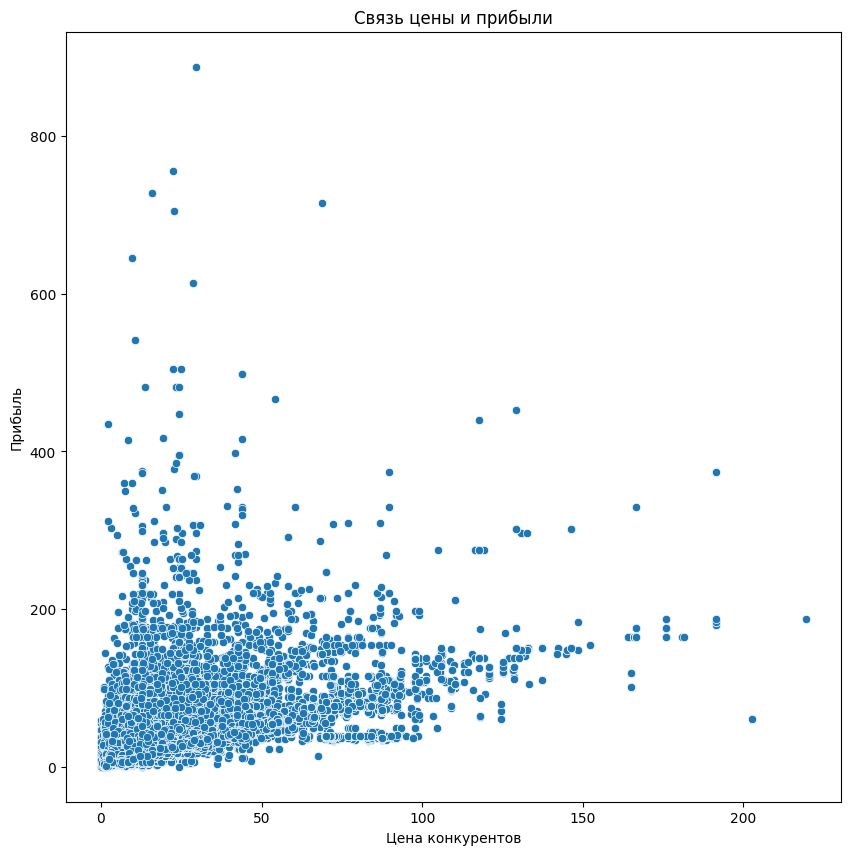

In [28]:
plt.figure(figsize=(10, 10))
df_temp = main_df[main_df['order']==1]
sns.scatterplot(data=df_temp, x='competitorPrice', y='revenue')
plt.title('Связь цены и прибыли')
plt.xlabel('Цена конкурентов')
plt.ylabel('Прибыль')

Что на этих картинках общего? При небольшой цене выручка особо не растёт ни у нас, ни на рынке. Но при росте цены наша выручка строко линейно начинает зависеть от цены, чего не происходит в таком явном виде у конкурентов. Это очень похоже как раз на то, что может дать динамическое ценообразование: если формировать цену динамически, исходя из спроса в реальном времени, то, может оказаться, что часть людей(готовых платить много) на самом деле может заплатить даже больше, чем мы думаем. Это отчасти подтверждается выбросами на диаграмме, где мы смотрели связь нашей цены и рыночной -- на рынке даже подумать не могли, что можно продать за ту цену, которая сформировалась у нас динамически. Возможно, именно такое ценообразование повлияло на рост прибыли в третьем месяце.

Давайте попробуем посмотреть на распределение прибыли(её логарифма, поможет немного сгладить выбросы и заодно проще будет работать именно с изменением прибыли)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


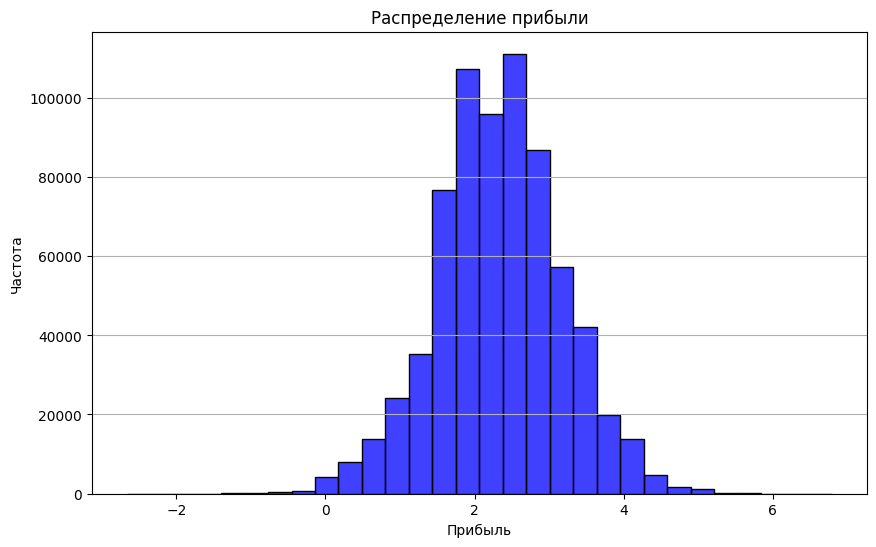

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(main_df['revenue']), bins=30, color='blue')
plt.title('Распределение прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

__Немного о возможных гипотезах:__Логарифм прибыли выглядит, как нормальное рапсределние. Возможно, мы можем сказать,что при большой цене, математическое ожидание логарфма прибыли будет равно математическому ожиданию логарифма нашей цены(раз уж они так хорошо связаны на больших значениях). Тогда получится, что наше ожидаемое изменение прибыли будет равно нашему ожидаемому изменению цены. Возможно это поможет нам лучше прогнозировать прибыль.

__А что с действиями покупателей?__


Рассмотрим второе направление и поработаем с конверсией.

<ipython-input-29-0b2a493e415f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index, y=action_counts.values, palette=colours)


Text(0, 0.5, 'Количество действий каждого типа')

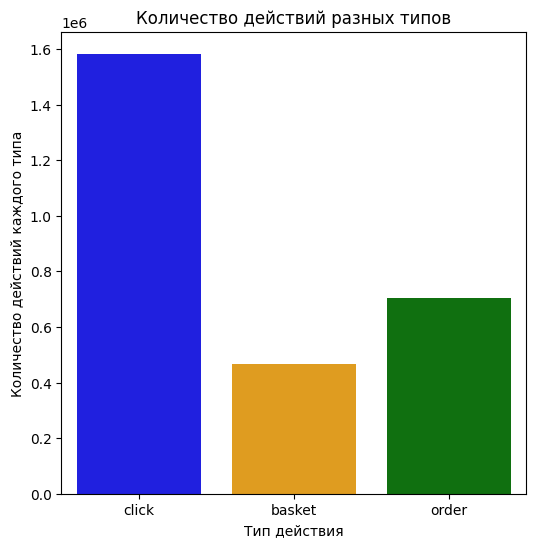

In [29]:
action_counts = main_df[['click', 'basket', 'order']].sum()

colours = ['blue', 'orange', 'green']

plt.figure(figsize=(6, 6))
sns.barplot(x=action_counts.index, y=action_counts.values, palette=colours)
plt.title('Количество действий разных типов')
plt.xlabel('Тип действия')
plt.ylabel('Количество действий каждого типа')

Посчитаем также конверсию.

In [35]:
conversion_click_basket = (main_df['basket'].sum() / main_df['click'].sum())
conversion_click_order = (main_df['order'].sum() / main_df['click'].sum())
conversion_basket_order = (main_df['basket'].sum() / main_df['order'].sum())
print(conversion_click_basket)
print(conversion_click_order)
print(conversion_basket_order)

0.2957278338062214
0.4454624542037759
0.6638670240678495


Можно попробовать посмотреть на совпадение столбцов 'adFlag' и 'order' и 'click'

In [45]:
share_matches = (main_df['adFlag'] == main_df['order']).sum() / len(main_df)
share_matches2 = (main_df['adFlag'] == main_df['click']).sum() / len(main_df)

print("Количество совпадений:", share_matches)
print("Количество совпадений:", share_matches2)

Количество совпадений: 0.6312808803183451
Количество совпадений: 0.39032794957044675


Можно выдвинуть гипотезу, что участие товара в рекалманой компании сильно влияет на его шансы быть купленным.

# Гипотезы и их проверка